In [3]:
# Let's start by making a fake dataset with a known slope.
x <- runif(200, min=-10, max=10)
y <- 2*x + 0.5 + rnorm(200, mean=0, sd=4)

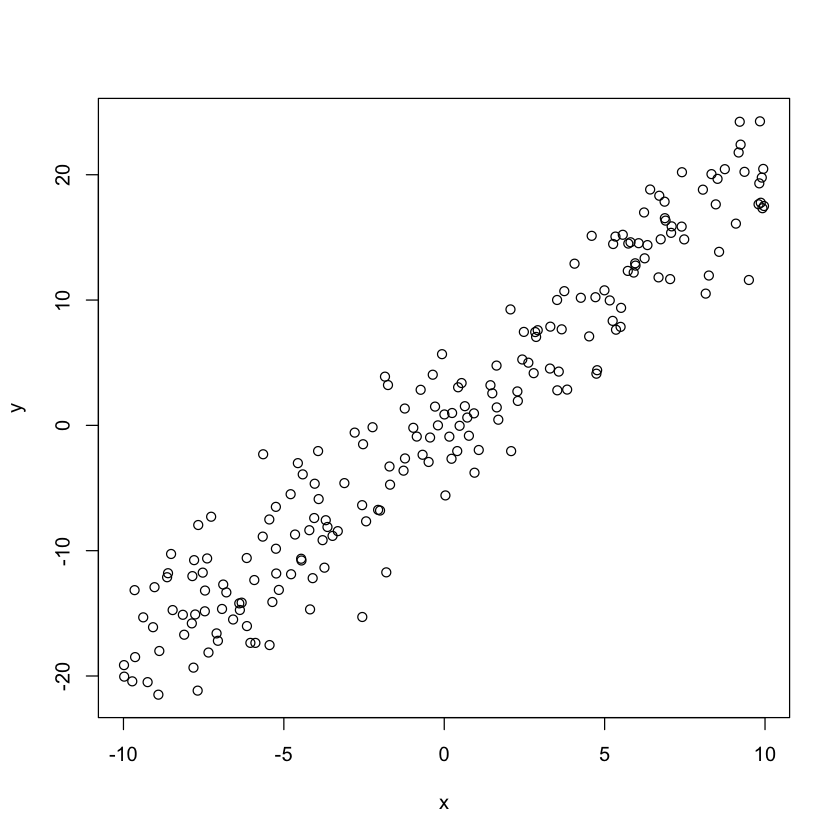

In [4]:
plot(x, y)

In [12]:
# Derive the batch linear regression solution and verify it against the lm function
batch_fit <- function(x, y) {
    w1 <- cov(x, y) / var(x)
    w0 <- mean(y) - w1 * mean(x)
    return(list(w0=w0, w1=w1))
}

params <- batch_fit(x, y)
print(paste0('Batch fit - w0 = ', params$w0, ', w1 = ', params$w1))

summary(lm(y ~ x, data=as.data.frame(cbind(x, y))))

[1] "Batch fit - w0 = 0.350707417249403, w1 = 1.99286524982825"



Call:
lm(formula = y ~ x, data = as.data.frame(cbind(x, y)))

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5511  -2.3182   0.0364   2.5191   8.5933 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.35071    0.24288   1.444     0.15    
x            1.99287    0.04145  48.078   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.435 on 198 degrees of freedom
Multiple R-squared:  0.9211,	Adjusted R-squared:  0.9207 
F-statistic:  2311 on 1 and 198 DF,  p-value: < 2.2e-16


In [22]:
# Make the online update function
online_update <- function(xnew, ynew, params) {
    # Update the means
    mu_x_n1 <- params$mu_x + (1 / (params$n + 1)) * (xnew - params$mu_x)
    mu_y_n1 <- params$mu_y + (1 / (params$n + 1)) * (ynew - params$mu_y)
    
    # Update the covariances
    cxx <- (1 / (params$n + 1)) * (xnew*xnew + params$n*params$cxx + params$n*params$mu_x*params$mu_x -
                                   (params$n+1)*mu_x_n1*mu_x_n1)
    cxy <- (1 / (params$n + 1)) * (xnew*ynew + params$n*params$cxy + params$n*params$mu_x*params$mu_y -
                                   (params$n+1)*mu_x_n1*mu_y_n1)
    
    # Update the weights
    w1 <- cxy / cxx
    w0 <- mu_y_n1 - w1 * mu_x_n1
    
    # Update the sample size
    n <- params$n + 1
    
    return(list(n=n, mu_x=mu_x_n1, mu_y=mu_y_n1, cxx=cxx, cxy=cxy, w0=w0, w1=w1))
}

init_params <- function(x, y) {
    n <- length(x)
    mu_x <- mean(x)
    mu_y <- mean(y)
    cxx <- var(x)
    cxy <- cov(x, y)
    return(list(n=n, mu_x=mu_x, mu_y=mu_y, cxx=cxx, cxy=cxy))
}

In [28]:
# Fit the model in an online fashion
params <- init_params(x, y)

w0s <- c(); w1s <- c()
for (i in seq(length(x))) {
    params <- online_update(x[i], y[i], params)
    w0s <- c(w0s, params$w0)
    w1s <- c(w1s, params$w1)
}

print(paste0('Final parameters: w0 = ', w0s[length(w0s)], ', w1 = ', w1s[length(w1s)]))

[1] "Final parameters: w0 = 0.350707417249403, w1 = 1.99286524982825"


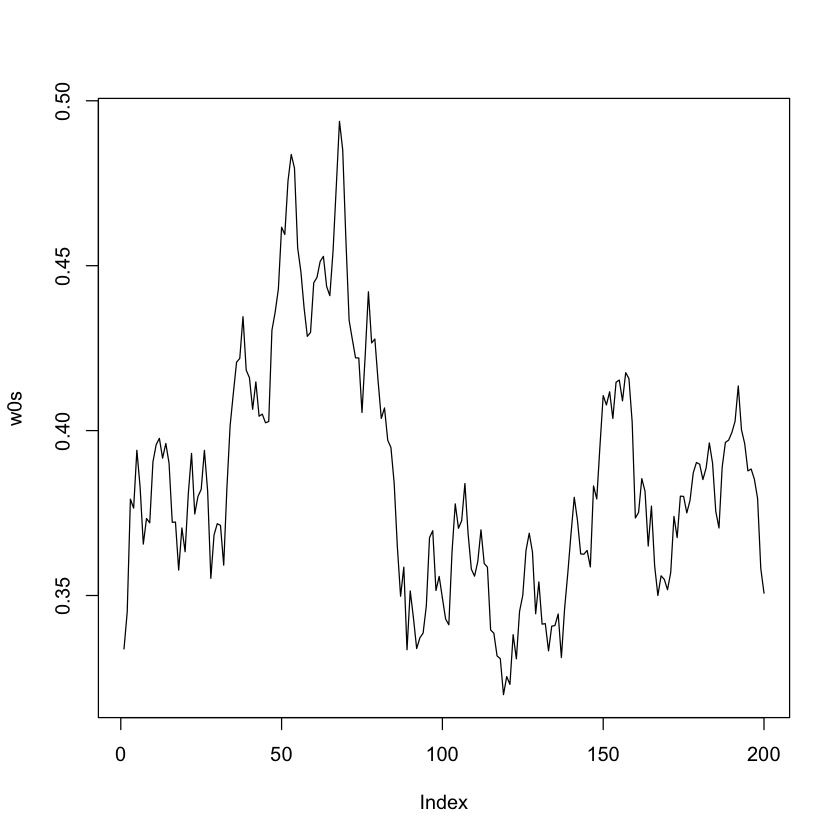

In [29]:
plot(w0s, type='l')

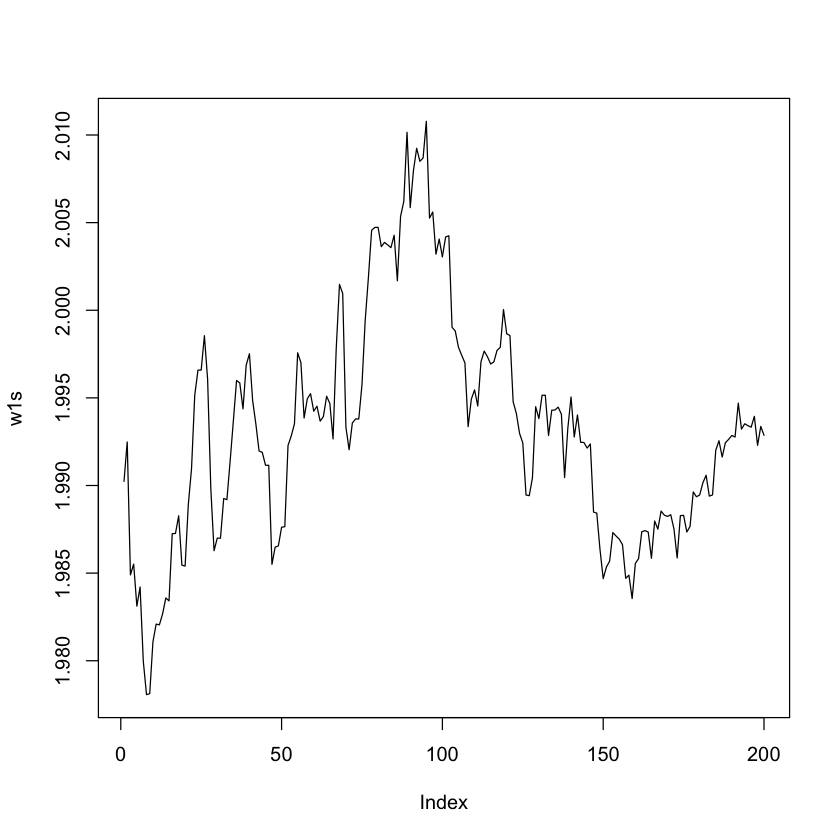

In [30]:
plot(w1s, type='l')